In [205]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import warnings
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [206]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
unchanged_attrition_df = xl.parse('HR-employee-attrition Data')
attrition_df = unchanged_attrition_df

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df

Attrition  Age  DailyRate  DistanceFromHome  Education  EmployeeNumber  \
0             1   41       1102                 1          2               1   
1             0   49        279                 8          1               2   
2             1   37       1373                 2          2               4   
3             0   33       1392                 3          4               5   
4             0   27        591                 2          1               7   
5             0   32       1005                 2          2               8   
6             0   59       1324                 3          3              10   
7             0   30       1358                24          1              11   
8             0   38        216                23          3              12   
9             0   36       1299                27          3              13   
10            0   35        809                16          3              14   
11            0   29        153                15          2              15   
12            0   31        670                26          1              16   
13            0   34       1346                19          2              18   
14            1   28        103                24          3              19   
15            0   29       1389                21          4              20   
16            0   32        334                 5          2              21   
17            0   22       1123                16          2              22   
18            0   53       1219                 2          4              23   
19            0   38        371                 2          3              24   
20            0   24        673                11          2              26   
21            1   36       1218                 9          4              27   
22            0   34        419                 7          4              28   
23            0   21        391                15          2              30   
24            1   34        699                 6          1              31   
25            0   53       1282                 5          3              32   
26            1   32       1125                16          1              33   
27            0   42        691                 8          4              35   
28            0   44        477                 7          4              36   
29            0   46        705                 2          4              38   
30            0   33        924                 2          3              39   
31            0   44       1459                10          4              40   
32            0   30        125                 9          2              41   
33            1   39        895                 5          3              42   
34            1   24        813                 1          3              45   
35            0   43       1273                 2          2              46   
36            1   50        869                 3          2              47   
37            0   35        890                 2          3              49   
38            0   36        852                 5          4              51   
39            0   33       1141                 1          3              52   
40            0   35        464                 4          2              53   
41            0   27       1240                 2          4              54   
42            1   26       1357                25          3              55   
43            0   27        994                 8          3              56   
44            0   30        721                 1          2              57   
45            1   41       1360                12          3              58   
46            0   34       1065                23          4              60   
47            0   37        408                19          2              61   
48            0   46       1211                 5          4              62   
49    

## Split into Train and Test Set

In [207]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1156, 52)
(314, 52)


## Data Exploration

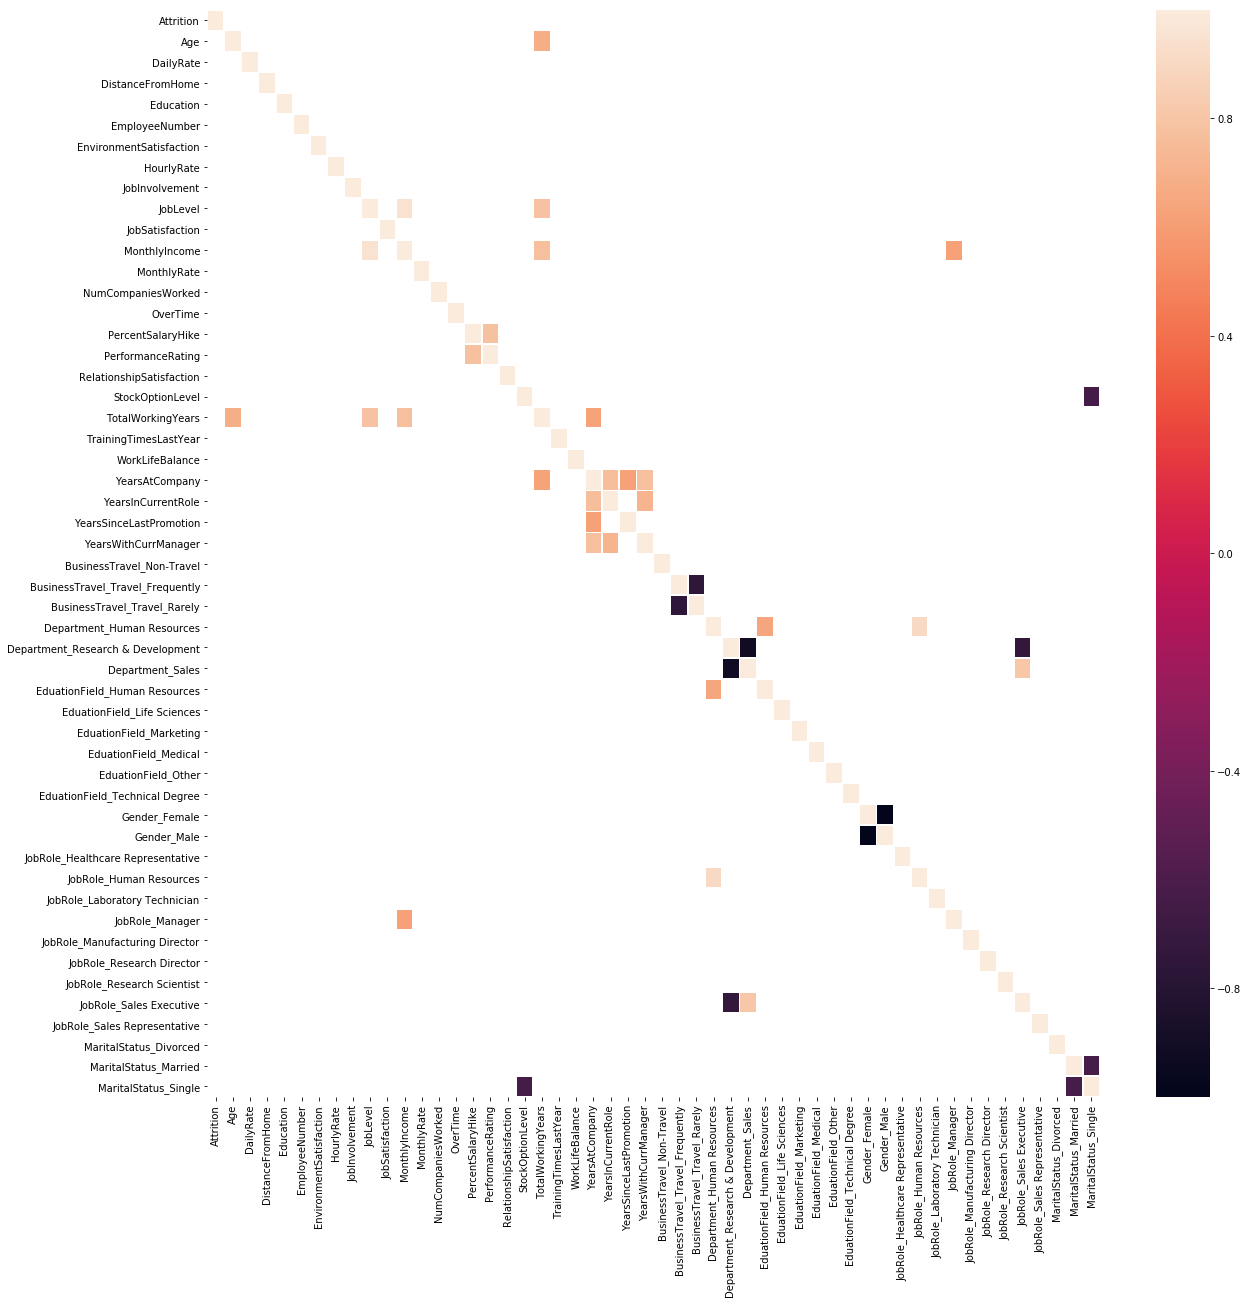

In [208]:
plt.figure(figsize = (20,20))
corr = attrition_df.corr()
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)

Based off looking at the correlation heatmap above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

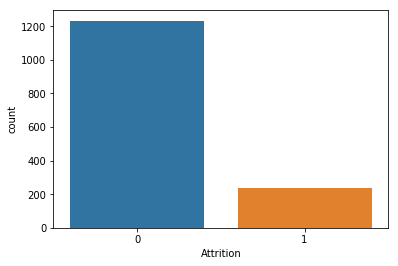

In [209]:
sns.countplot(x='Attrition',data=attrition_df)
plt.show()

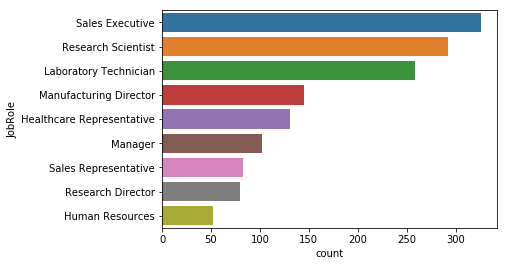

In [210]:
sns.countplot(y="JobRole", data=unchanged_attrition_df)
plt.show()

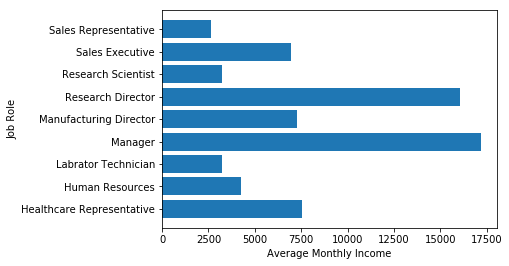

In [211]:
income = unchanged_attrition_df.groupby('JobRole').mean()[['MonthlyIncome']].values
flattened_income = []
for i in income:
    flattened_income.append(i[0])
    
roles = ['Healthcare Representative', 'Human Resources', 'Labrator Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist' , 'Sales Executive','Sales Representative']

y_pos = np.arange(len(roles))

plt.xlabel('Average Monthly Income')
plt.ylabel('Job Role')
 
# Create horizontal bars
plt.barh(y_pos, flattened_income)
 
# Create names on the y-axis
plt.yticks(y_pos, roles)
 
# Show graphic
plt.show()

## Modeling

### Recursive Feature Elimination

In [212]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

predictions = rfe.predict(X_test)
print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))


[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False  True False False False False False  True False False False False
 False False False False False False False False False False False  True
 False False  True]
[39 44 36 30 46 12 43  5  8 14 45 47 25  1 42 32 20 35 41 24 16 34 22 21
 29  1  4 15 23 38  7  1 28  9 31 27  3 19 13 18  6  2 11 33 10 37 40  1
 17 26  1]
['OverTime' 'BusinessTravel_Non-Travel' 'EduationField_Human Resources'
 'JobRole_Sales Representative' 'MaritalStatus_Single']
Accuracy of RFE on test set: 0.84395


### Feature Importance With ExtraTreesClassifier

In [213]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.039 0.024 0.033 0.028 0.027 0.037 0.023 0.034 0.028 0.028 0.032 0.023
 0.028 0.068 0.022 0.01  0.025 0.017 0.035 0.026 0.029 0.029 0.021 0.031
 0.031 0.01  0.019 0.013 0.001 0.011 0.007 0.004 0.016 0.011 0.018 0.005
 0.012 0.012 0.019 0.005 0.003 0.012 0.002 0.006 0.005 0.013 0.008 0.013
 0.01  0.012 0.027]
['OverTime', 'Age', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'JobInvolvement']
Accuracy of extra trees classifier on test set: 0.85032


### Random Forrest

In [214]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

# preds = iris.target_names[clf.predict(test[features])]
train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
9
Not Attrition count: 
305
Accuracy of random forrest on test set: 0.86624
[(0.0783, 'MonthlyIncome'), (0.0503, 'DailyRate'), (0.0495, 'OverTime'), (0.0493, 'EmployeeNumber'), (0.0482, 'Age')]


### Logistic Regression

In [215]:
warnings.filterwarnings('ignore')

logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))


Accuracy of logistic regression classifier on test set: 0.90127


In [216]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

print(sorted(list(zip(p_values, columns_without_attrition)))[:5])

[(2.339861006265607e-14, 'OverTime'), (1.645631667431658e-05, 'NumCompaniesWorked'), (0.00016304632921176836, 'EnvironmentSatisfaction'), (0.0002611569794997099, 'YearsAtCompany'), (0.0003841105545079981, 'YearsWithCurrManager')]


## Interesting Trends

We will looks at trends in job roles vs some of the factors that were selected in the different models.

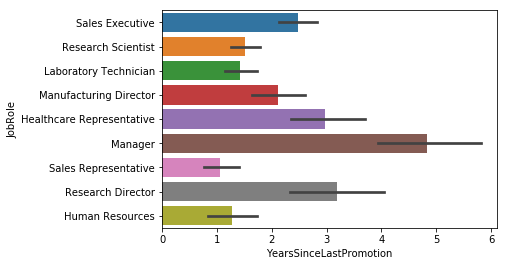

In [217]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole", data=unchanged_attrition_df)

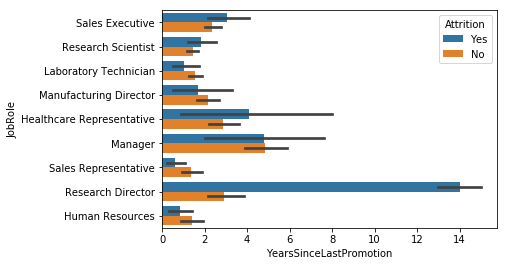

In [218]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

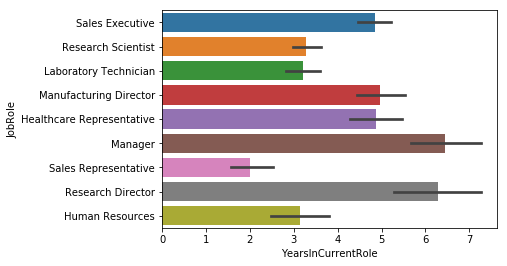

In [219]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", data=unchanged_attrition_df)

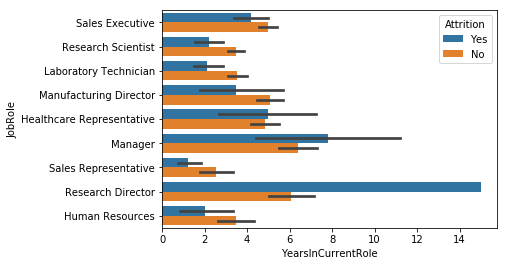

In [220]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

In [221]:
unchanged_attrition_df.corr()[["YearsSinceLastPromotion"]]["YearsInCurrentRole":"YearsInCurrentRole"]

YearsSinceLastPromotion
YearsInCurrentRole                 0.548056

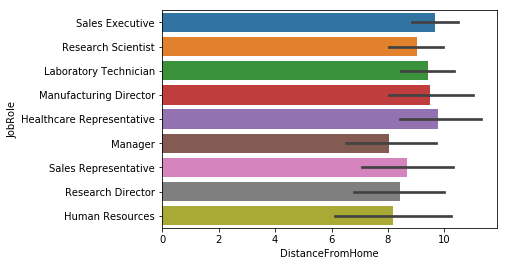

In [222]:
sns.barplot(x="DistanceFromHome", y="JobRole", data=unchanged_attrition_df)

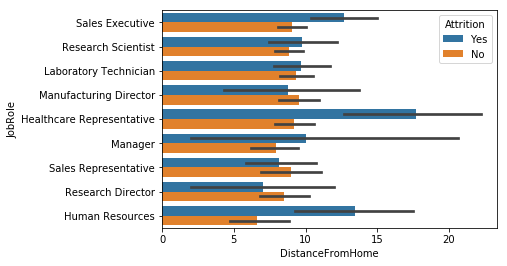

In [223]:
sns.barplot(x="DistanceFromHome", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

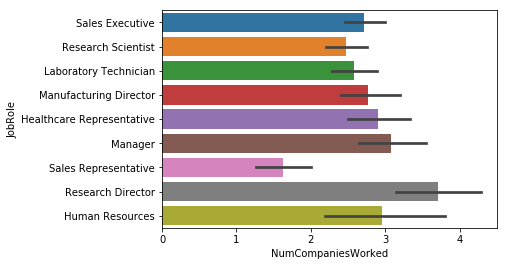

In [224]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", data=unchanged_attrition_df)

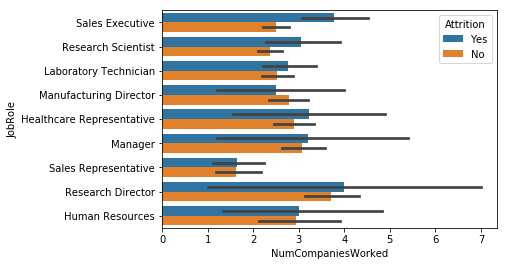

In [225]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", hue="Attrition", data=unchanged_attrition_df)

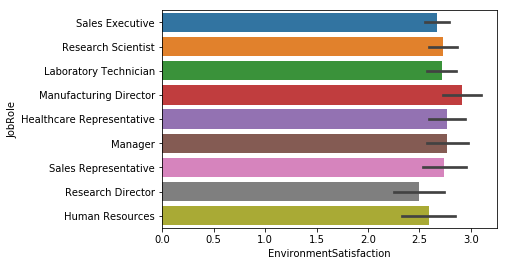

In [226]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole", data=unchanged_attrition_df)

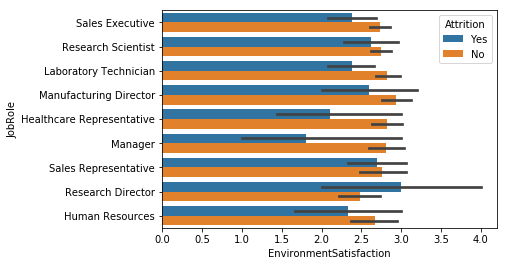

In [227]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

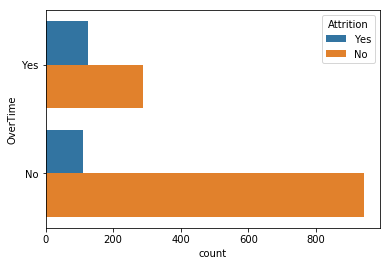

In [228]:
sns.countplot(y="OverTime", hue="Attrition", data=unchanged_attrition_df)

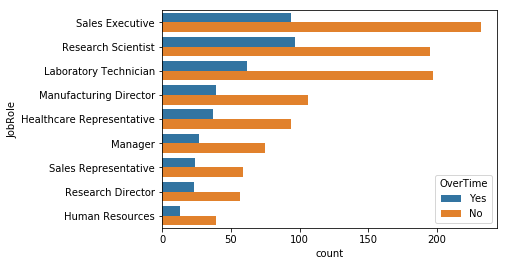

In [229]:
sns.countplot(y="JobRole", hue="OverTime", data=unchanged_attrition_df)

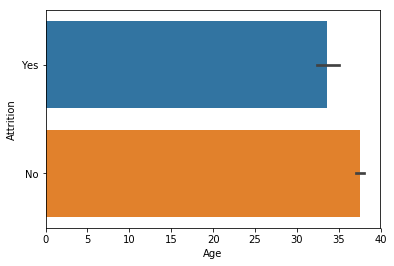

In [230]:
sns.barplot(x="Age", y="Attrition", data=unchanged_attrition_df)

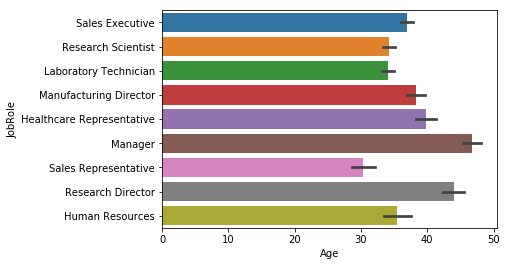

In [231]:
sns.barplot(x="Age", y="JobRole", data=unchanged_attrition_df)

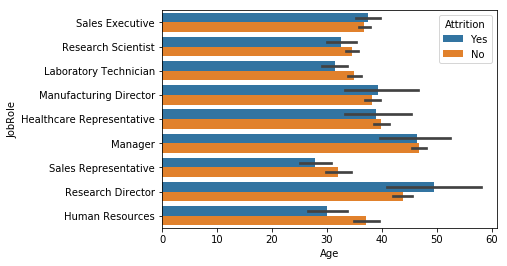

In [232]:
sns.barplot(x="Age", y="JobRole", hue="Attrition", data=unchanged_attrition_df)